In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# FY 2019 Analysis

In [4]:
df = pd.read_csv("2019_uiuc_electricity_demand.csv",
                 skiprows=1,
                 parse_dates=True,
                 usecols=['Date and Time', 'Value (KW)'],
                 index_col = ['Date and Time'])
demd2019 = df.rename(columns={"Value (KW)":"kW"})

df = pd.read_csv("willard_weather_data.csv",
                 parse_dates=True, usecols=['DATE', 'HourlyWetBulbTemperature'],
                 index_col = ['DATE'])
df = df.rename(columns={"HourlyWetBulbTemperature":"temperature"})  # temperature in F
temp2019 = df['06/30/2018 23:53':'06/30/2019 23:53'].dropna()

temp_daterange = pd.date_range(start='06/30/2018 23:53', end='06/30/2019 22:53', freq='h')
demd_daterange = demd2019.index

# remove values outside temp_daterange and flag empty values
temp = []
for date in temp_daterange:
    if (temp2019.index == date).any() == True:
        addtempt = temp2019[temp2019.index == date].to_string(columns=['temperature'], header=False, index=False)
        temp.append(float(addtempt))
    else:
        temp.append('empty')

temp2019 = pd.DataFrame(temp, index=demd_daterange, columns=['temperature'])
temp2019

/home/roberto/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,temperature
Date and Time,
2018-07-01 00:00:00,74
2018-07-01 01:00:00,73
2018-07-01 02:00:00,72
2018-07-01 03:00:00,72
2018-07-01 04:00:00,72
...,...
2019-06-30 19:00:00,68
2019-06-30 20:00:00,68
2019-06-30 21:00:00,69


In [6]:
# merge dataframes and remove empty values
df = pd.concat([demd2019, temp2019], axis=1)
df = df[df.temperature != 'empty']
df

,kW,temperature
Date and Time,,
2018-07-01 00:00:00,59694.0,74
2018-07-01 01:00:00,57231.0,73
2018-07-01 02:00:00,56295.0,72
2018-07-01 03:00:00,55830.0,72
2018-07-01 04:00:00,54994.0,72
...,...,...
2019-06-30 19:00:00,55136.0,68
2019-06-30 20:00:00,54423.0,68
2019-06-30 21:00:00,57478.0,69


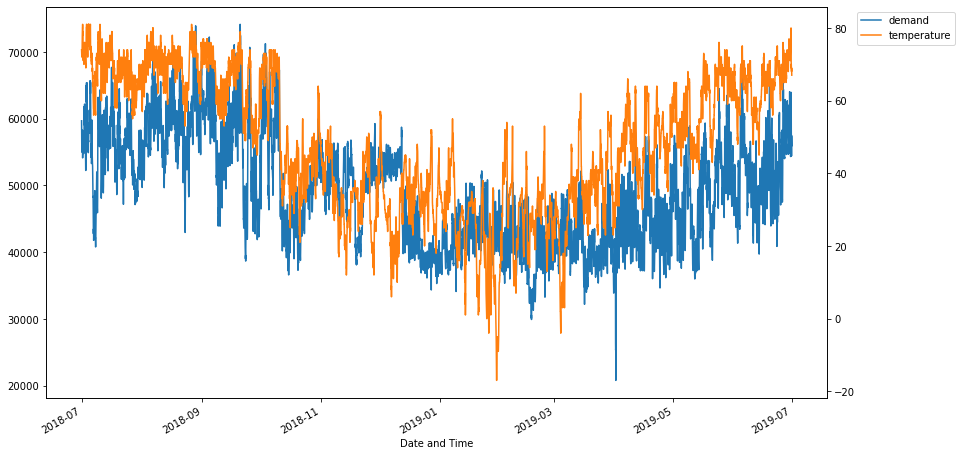

In [75]:
# plot demand along with the temperature
fig, ax = plt.subplots(figsize=(14,8))
df.kW.plot(ax=ax)
df.temperature.plot(ax=ax, secondary_y=True)
ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]], ['demand','temperature'], bbox_to_anchor=(1.17, 1.0))

Text(0, 0.5, 'Demand [kW]')

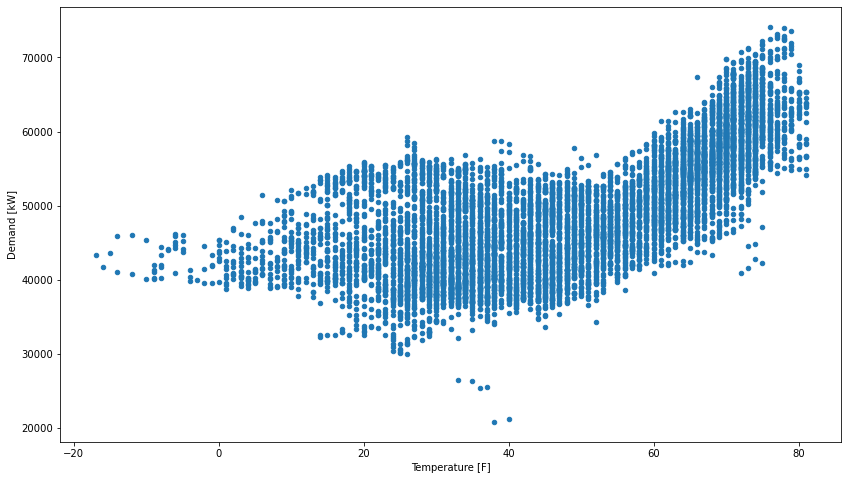

In [30]:
ax = df.plot.scatter(x='temperature', y='kW', figsize=(14, 8))
ax.set_xlabel("Temperature [F]")
ax.set_ylabel("Demand [kW]")

# 2019 Month-by-month analysis

In [8]:
def demand_vs_temperature_polynomial_regression(dataframe, order):
    '''
    Parameters:
    -----------
    dataframe: [pandas dataframe]
        index: date and time
        columns: kw, temperature
    order: [int]
        polynomial regression order
    Returns:
    --------
    None
    '''

    train_X = dataframe['temperature'].to_numpy().reshape(-1, 1)
    train_Y = dataframe['kW'].to_numpy().reshape(-1, 1)

    # plot original data
    plt.figure(figsize=(14, 8))
    plt.scatter(train_X, train_Y, label='Data')
    plt.xlabel("Temperature [F]")
    plt.ylabel("Demand [kW]")

    # obtain prediction
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree = order, include_bias = False) 
    poly_X = poly_features.fit_transform(train_X)
    model.fit(poly_X, train_Y)
    transformed_X = poly_features.transform(train_X)
    pred_Y = model.predict(transformed_X)

    # sort values for plotting
    sort_Y = np.array([Y for _, Y in sorted(zip(train_X, pred_Y))])
    sort_X = np.sort(train_X, axis=0)

    regression_label = 'Regression: y='
    for i in range(model.coef_.shape[1]-1, -1, -1):
        regression_label += '(' + str(round(model.coef_[0][i], 2)) + ')'
        regression_label += 'x^' + str(i+1) + '+'

    regression_label += '(' + str(round(model.intercept_[0], 2)) + ')'
    plt.plot(sort_X, sort_Y, color='red', linestyle='dashed', label=regression_label)
    plt.legend(loc='best')

    # print(f'coeficients: {model.coef_}')  # if [a b] then f(x) = a*x + b*x^2
    # print(f'independent coeficient: {model.intercept_}')
    print(f'R-squared: {r2_score(pred_Y, train_Y)}')
    return None

R-squared: 0.07213382185676165


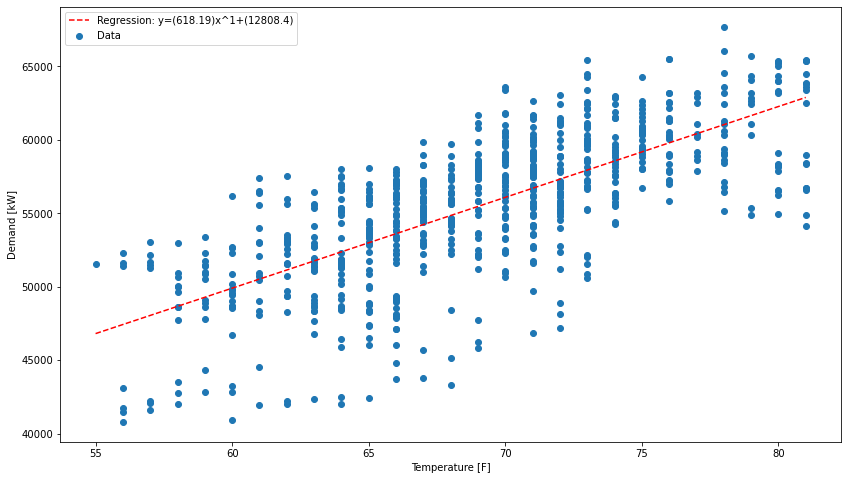

In [14]:
# July 2018
demand_vs_temperature_polynomial_regression(df['07/01/2018 00:00':'08/01/2018 00:00'], 1)

R-squared: -0.3578395525459874


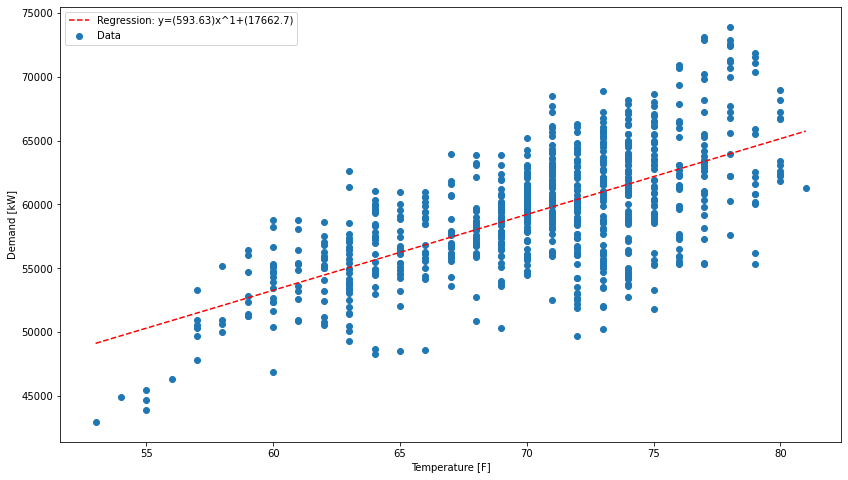

In [15]:
# August 2018
demand_vs_temperature_polynomial_regression(df['08/01/2018 00:00':'09/01/2018 00:00'], 1)

R-squared: 0.6760217619647517


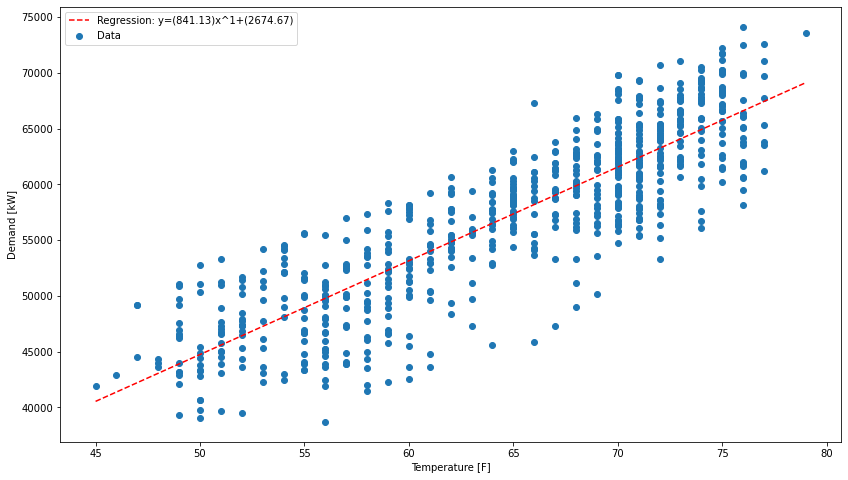

In [16]:
# September 2018
demand_vs_temperature_polynomial_regression(df['09/01/2018 00:00':'10/01/2018 00:00'], 1)

R-squared: 0.6121273467323671


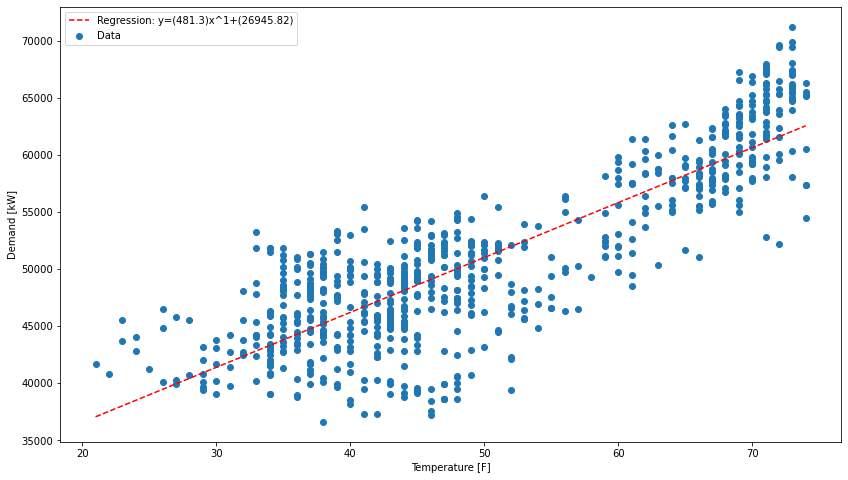

In [17]:
# October 2018
demand_vs_temperature_polynomial_regression(df['10/01/2018 00:00':'11/01/2018 00:00'], 1)

R-squared: -418.7155670371437


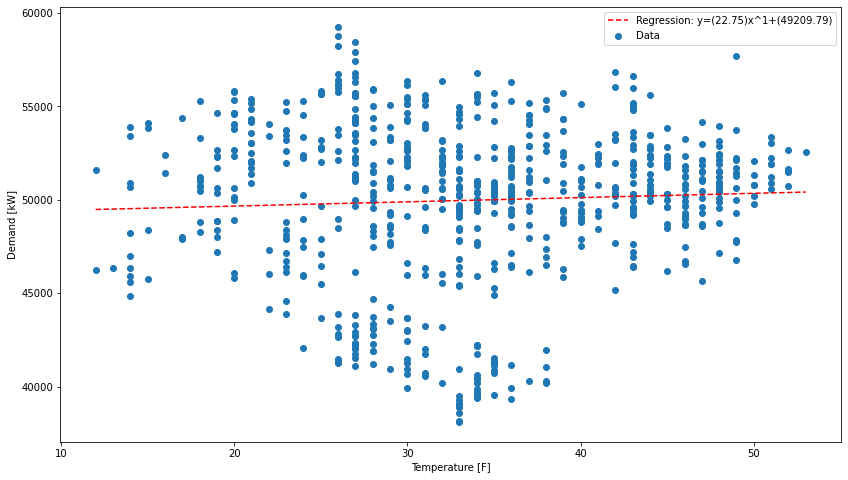

In [18]:
# November 2018
demand_vs_temperature_polynomial_regression(df['11/01/2018 00:00':'12/01/2018 00:00'], 1)

R-squared: -16.015644539344294


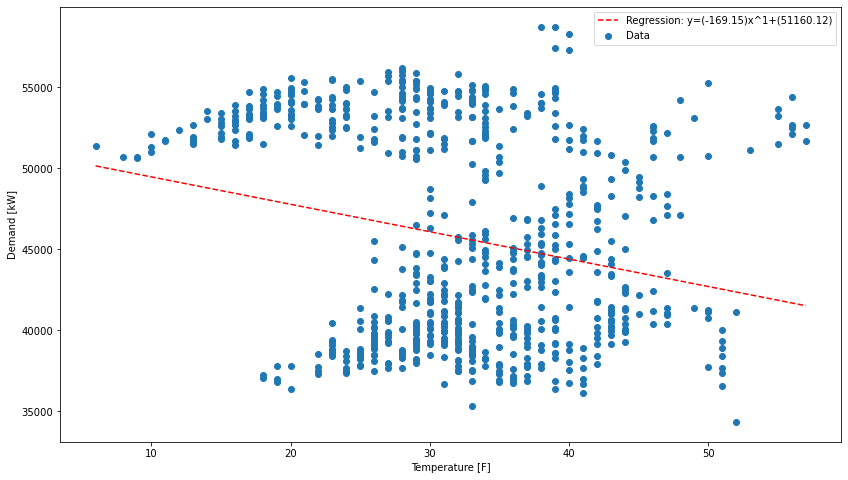

In [19]:
# December 2018
demand_vs_temperature_polynomial_regression(df['12/01/2018 00:00':'01/01/2019 00:00'], 1)

R-squared: -45.54029078820071


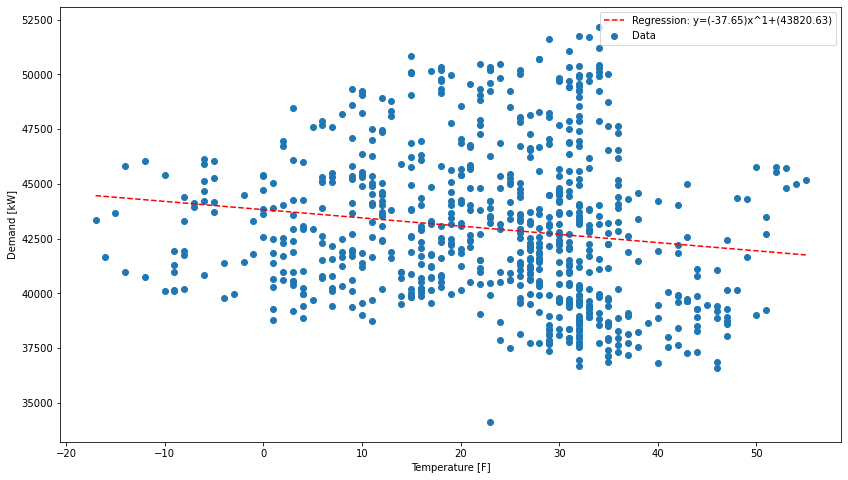

In [20]:
# January 2019
demand_vs_temperature_polynomial_regression(df['01/01/2019 00:00':'02/01/2019 00:00'], 1)

R-squared: -25.95547339967162


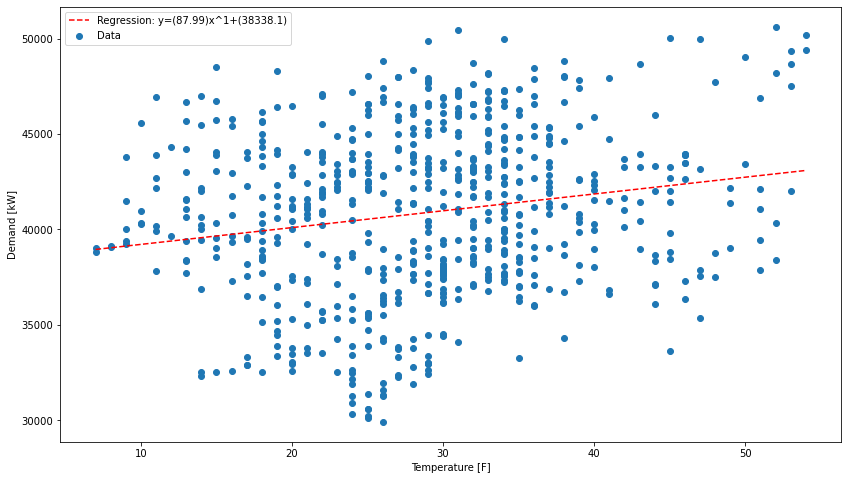

In [21]:
# February 2019
demand_vs_temperature_polynomial_regression(df['02/01/2019 00:00':'03/01/2019 00:00'], 1)

R-squared: -15.428790527153438


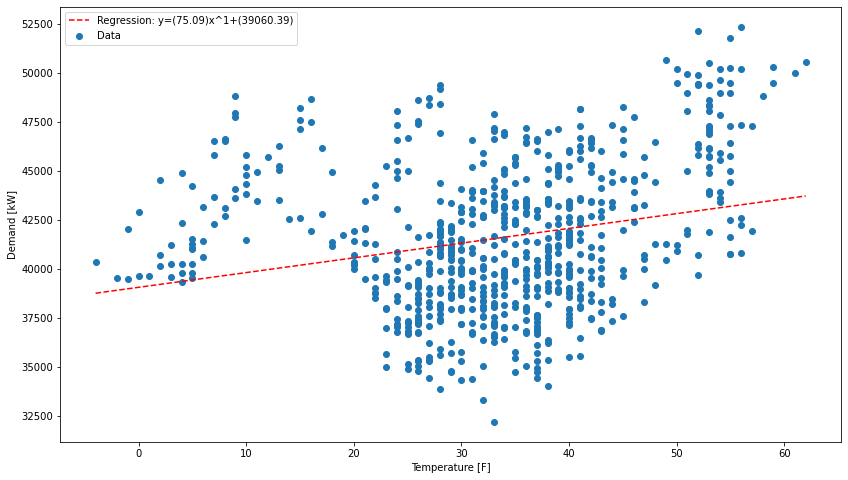

In [22]:
# March 2019
demand_vs_temperature_polynomial_regression(df['03/01/2019 00:00':'04/01/2019 00:00'], 1)

R-squared: -0.5595976258078312


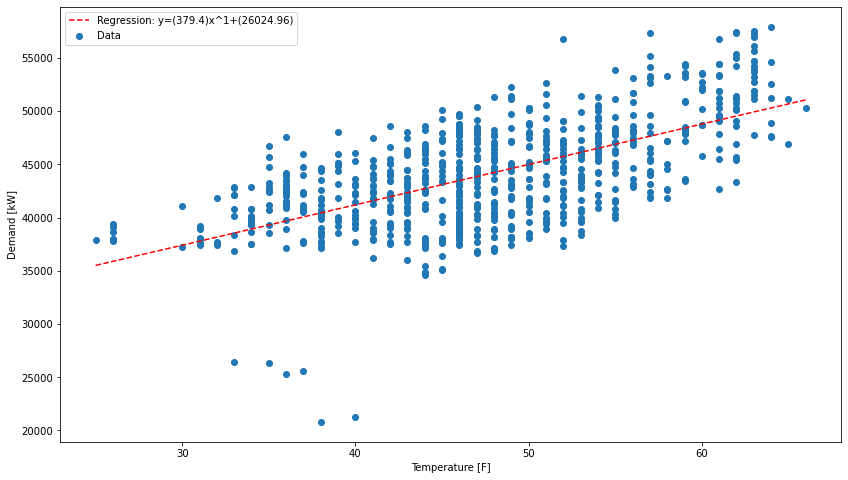

In [23]:
# April 2019
demand_vs_temperature_polynomial_regression(df['04/01/2019 00:00':'05/01/2019 00:00'], 1)

R-squared: 0.5804642341780151


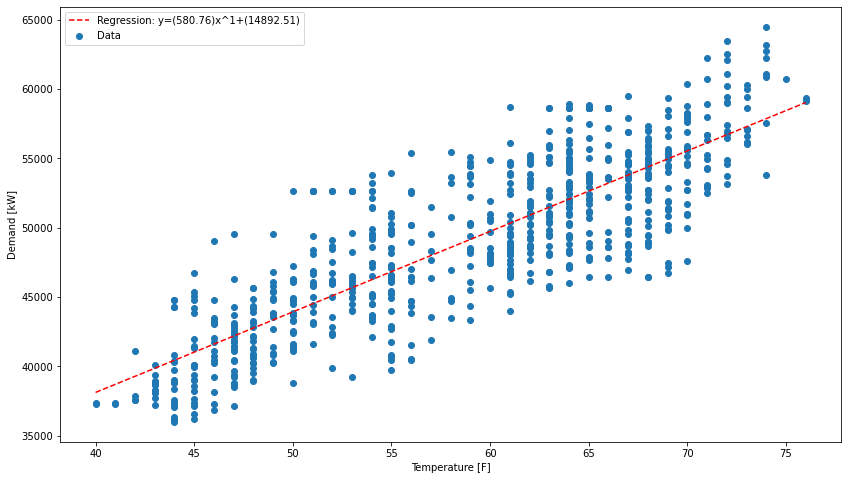

In [24]:
# May 2019
demand_vs_temperature_polynomial_regression(df['05/01/2019 00:00':'06/01/2019 00:00'], 1)

R-squared: 0.06536030114441937


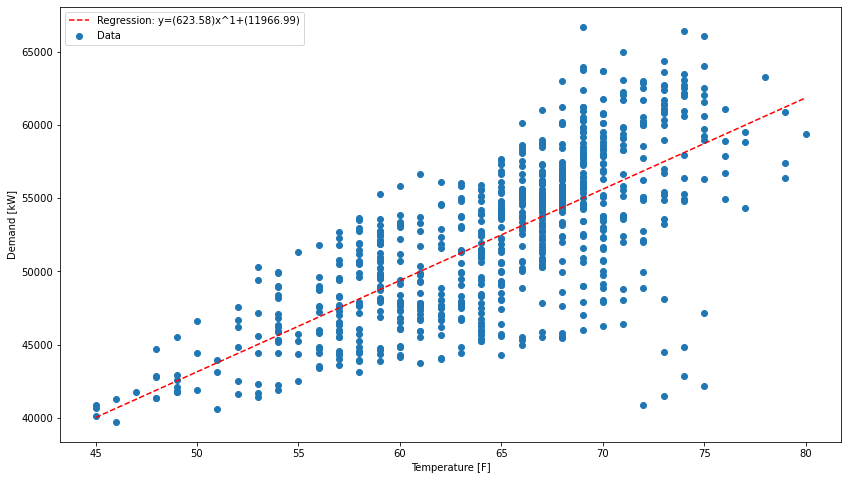

In [29]:
# June 2019
demand_vs_temperature_polynomial_regression(df['06/01/2019 00:00':'07/01/2019 00:00'], 1)